<a href="https://colab.research.google.com/github/bf319/Scaling_MPNNs/blob/main/make_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

roc_vs_number_of_params_url = "https://docs.google.com/spreadsheets/d/1vbInj1sfZU5Cgl5E12x3QX1th0JAajpUTFrVRAGNsa8/gviz/tq?tqx=out:csv&sheet=Sheet1"
roc_vs_batch_size = "https://docs.google.com/spreadsheets/d/18dA_TvqA-CcARlBACaRCcfKoZZCQr4j71DXiznzml9k/gviz/tq?tqx=out:csv&sheet=Sheet1"

df_number_of_params = pd.read_csv(roc_vs_number_of_params_url)
df_batch_size = pd.read_csv(roc_vs_batch_size)

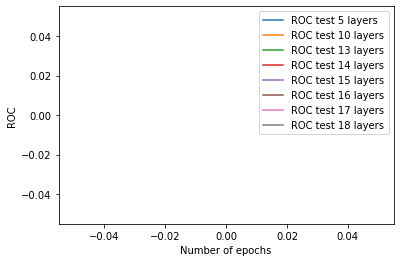

In [4]:
import matplotlib.pyplot as plt

def plot_number_of_params_vs_roc():
  data_to_plot = {}

  message_passing_steps_evaluated = [5, 10, 13, 14, 15, 16, 17, 18]

  for num_message_passing_steps in message_passing_steps_evaluated:
    epochs = []
    roc_train = []
    roc_valid = []
    roc_test = []
    
    for index, row in df_batch_size.iterrows():
      if row['Message passing steps'] == num_message_passing_steps:
        epochs.append(row['Epoch'])
        roc_train.append(row['ROC train'])
        roc_valid.append(row['ROC eval'])
        roc_test.append(row['ROC test'])

    data_to_plot[num_message_passing_steps] = {
        'epochs': epochs,
        'roc_train': roc_train,
        'roc_valid': roc_valid,
        'roc_test': roc_test
    }

  for num_message_passing_steps in message_passing_steps_evaluated:
    plt.plot(data_to_plot[num_message_passing_steps]['epochs'], data_to_plot[num_message_passing_steps]['roc_test'], label = f'ROC test {num_message_passing_steps} layers')

  plt.xlabel('Number of epochs')
  plt.ylabel('ROC')

  plt.legend()
  plt.show()

plot_number_of_params_vs_roc()